# Unfair Dice

### Multinomial distribution

We are dealing with a discrete probability problem, involving a dice with six faces. 

There are thus six possible outcomes for a roll, with probabilities given by the weights. 
The multinomial distribution models the probability of achieving a given count of 1's, ..., 6's over $N$ rolls, given the weights $w_1, \dots, w_6$. 

Calling $C_i$ the count of i's, the expected value of $C_i$ is $E[C_i] = N w_i$, whereas its variance is $\textrm{Var}[C_i] = N w_i(1-w_i)$, as in the binomial case; moreover, the probability mass function -- discrete analogue of the PDF -- is given by
$$f(C_1, \dots, C_6) = \frac{N!}{C_1! \cdots C_6!} w_1^{C_1} \cdots w_6^{C_6}$$


See also
* https://timothyweber.org/node/255
* http://deltasdnd.blogspot.com/2011/10/testing-balanced-dice-power.html

## Imports and instantiation of a random number generator

In [1]:
# To run all the expressions in each cell. 
# To return to the default behavior, write: InteractiveShell.ast_node_interactivity = "last_expr"

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
from numpy.random import default_rng
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
seed = 42
gen = default_rng(seed)

## Sampling from a probability distribution

#### A few basic examples

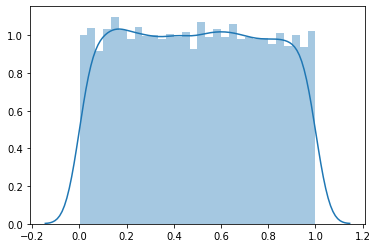

In [4]:
# Uniform distribution

values = gen.uniform(0, 1, 10000)

sns.distplot(values, bins=30)
plt.show();

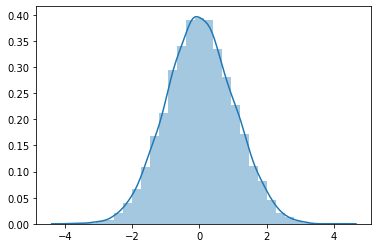

In [5]:
# Normal distribution

values = gen.normal(0, 1, 10000)

sns.distplot(values, bins=30)
plt.show();

## Simulating unfair dice

### Generating the weights

In [6]:
# Weights for a fair dice

std_weights = np.array([1/6]*6)

We will be generating random weights by rescaling a bunch of numbers drawn from a uniform distribution.

In [7]:
def gen_weights(n_weights=6, sum=1): 
    arr = gen.uniform(0,1,n_weights)
    return arr/(arr.sum())

# A quick function to check that a collection of weights is legitimate 
# (relevant for manually input weights, as our function guarantees that they add up to 1)

def check_weights(weights):
    return np.isclose(weights.sum(), 1.0)    # The .isclose() method accommodates small imprecisions

Of course obtaining by chance a roughly uniform distribution of weights is extremely unlikely if n_weights is larger than 2 or 3. For this reason it is useful to code a function generating weights that are just moderately off those of a fair dice.

The *upto* parameter specifies the allowed relative discrepancy (default is 10%). In particular, setting *upto=0* forces the weights to be those of a fair dice.

In [8]:
def gen_close_weights(upto=0.1, n_weights=6, sum=1):
    arr_perc = gen.uniform(-upto, upto, n_weights)
    arr = np.array([(1 + arr_perc[i])/n_weights for i in range(n_weights)])
    return arr/(arr.sum())

#### Examples

In [9]:
for i in range(5):
    w = gen_weights()
    print('Weights: {}'.format(w) + '   Sum to 1? {}'.format(check_weights(w)))

Weights: [0.17447928 0.09322567 0.00414993 0.06721468 0.41501524 0.2459152 ]   Sum to 1? True
Weights: [0.06304619 0.2960062  0.2498492  0.03628259 0.08532763 0.26948819]   Sum to 1? True
Weights: [0.23854655 0.32574557 0.02626835 0.26713347 0.02632416 0.1159819 ]   Sum to 1? True
Weights: [0.29203667 0.27660799 0.00082391 0.07856293 0.30289266 0.04907584]   Sum to 1? True
Weights: [0.15876465 0.08945172 0.05421625 0.40697053 0.02983925 0.26075761]   Sum to 1? True


In [10]:
for i in range(5):
    w = gen_close_weights()
    print('Weights: {}'.format(w) + '   Sum to 1? {}'.format(check_weights(w)))

print('\nWeights: {}'.format(gen_close_weights(upto=0)) + '   Sum to 1? {}'.format(check_weights(w)))

Weights: [0.17109881 0.15017287 0.16914672 0.15928275 0.17574064 0.17455821]   Sum to 1? True
Weights: [0.17585123 0.16272223 0.17680269 0.17040609 0.16205854 0.15215922]   Sum to 1? True
Weights: [0.1538222  0.16003942 0.16166235 0.18281311 0.18525205 0.15641087]   Sum to 1? True
Weights: [0.17328165 0.16576085 0.15914091 0.1736611  0.16598858 0.16216691]   Sum to 1? True
Weights: [0.16307765 0.16428674 0.18738507 0.16326852 0.156941   0.16504103]   Sum to 1? True

Weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]   Sum to 1? True


### Tossing the (loaded) dice

#### Writing the drawing function from scratch

We split the interval [0,1] into six bins of variable width (based on the desired weights) and translate the outcome of the draws based on that choice of bins.

In [11]:
# Caveman's approach
def dice_roll_caveman(weights, size=1000):
    
    bins_l = np.array([sum(weights[:i]) for i in range(len(weights))])
    array = np.empty(size)
    for i in range(size):
        drawn = gen.uniform()
        if drawn < bins_l[1]:
            array[i] = 1
        elif drawn < bins_l[2]:
            array[i] = 2
        elif drawn < bins_l[3]:
            array[i] = 3
        elif drawn < bins_l[4]:
            array[i] = 4
        elif drawn < bins_l[5]:
            array[i] = 5
        else:
            array[i] = 6
            
    return array
    
# Using sorting
def dice_roll_sorting(weights, size=1000):
    
    bins_l = np.array([sum(weights[:i]) for i in range(len(weights))])
    array = np.empty(size)
    for i in range(size):
        drawn = gen.uniform()
        lst = np.sort(np.append(bins_l, drawn))
        array[i] = np.where(lst == drawn)[0]   # [0] is to avoid ValueError: setting an array element with a sequence.
    
    return array

#### Taking advantage of the built-in method *choice* [(link)](https://stackoverflow.com/questions/4265988/generate-random-numbers-with-a-given-numerical-distribution/41852266)

In [12]:
# Using the .choice() method
def dice_roll(weights, size=6000):
    return gen.choice(np.arange(1, 7), size=size, p=weights)

#### Comparing performances

Timing shows that the built-in method is way faster; the caveman's approach clearly beats the sorting!

In [13]:
weights = gen_weights()

%timeit dice_roll_caveman(weights, size=1000)

%timeit dice_roll_sorting(weights, size = 1000)

%timeit dice_roll(weights, size = 1000)

5.59 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
29.7 ms ± 5.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
89.9 µs ± 7.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Plotting histograms

In [14]:
sns.set_style('whitegrid')

The weights are approximately (0.13, 0.25, 0.21, 0.19, 0.1, 0.12)


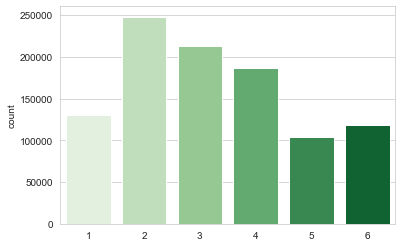

In [15]:
weights = gen_weights()
print('The weights are approximately (' + ', '.join(map(str,weights.round(2))) + ')')

values = dice_roll(weights, size=1000000)
sns.countplot(values, palette='Greens')
plt.show();

The weights are approximately (0.16, 0.16, 0.17, 0.16, 0.18, 0.16)


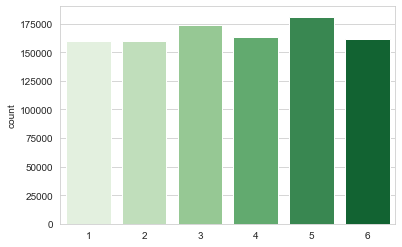

In [16]:
weights = gen_close_weights()
print('The weights are approximately (' + ', '.join(map(str,weights.round(2))) + ')')

values = dice_roll(weights, size=1000000)
sns.countplot(values, palette='Greens')
plt.show();

## Statistical analysis

At first we will find it convenient to draw samples from the multinomial distribution, rather than simulating a number of dice tosses and subsequently count the number of times each face was rolled. However, for the sake of the bootstrap analysis we will need to be able to go back and forth between the two representations (of course it isn't one-to-one, but it won't matter).

### Preliminaries

In [17]:
# Sampling from the multinomial distribution (gives the count for all faces, not an array of tossed faces)

def dice_roll_count_multinom(weights, size=6000):
    return gen.multinomial(n=size, pvals=weights)

# Converting counts in an array of outcomes (sorted, but it will then be shuffled)

def expand_counts(counts):
    arr = [[i+1]*counts[i] for i in range(len(counts))]
    return np.concatenate(arr)

# Counting the number of times every face was rolled

def dice_roll_count(sample):
    counts = np.unique(sample, return_counts=True)
    return counts[1]    

### $\chi^2$ analysis

Suppose we are given the 6-tuple $(C_1, \dots, C_6)$ and we have to decide whether such an outcome is compatible with the null hypothesis of a fair dice. 

We define the test statistic $\displaystyle \chi^2 = \sum_{i=1}^6 \frac{(C_i - E[C_i])^2}{E[C_i]}$, where $E[C_i]$ is the expected count $C_i$ *assuming the null hypothesis is true*, i.e. $E[C_i] = \frac16 \sum_i C_i$.

In [18]:
# Function to compute the chi^2 test statistic

def compute_chi2(counts):
    expected = np.sum(counts)/6
    summands = [(counts[i] - expected)**2 / expected for i in range(len(counts))]

    return np.sum(summands)

We sample from the multinomial distribution corresponding to a fair dice and compute the values of the test statistic for all elements in our sample. They are distributed in some way (we wouldn't even need to know, however it's a $\chi^2$ distribution with 5 degrees of freedom) and we can look at how much towards the tails our original value is. After fixing a confidence level, we can decide whether or not to reject the null hypothesis that the dice is fair.

In [19]:
def sampling_chi2(n_samples=10000):
    stat_values = np.empty(n_samples)
    for i in range(n_samples):
        stat_values[i] = compute_chi2(dice_roll_count_multinom(gen_close_weights(upto=0)))
    
    return stat_values

def is_unfair(sampled_values, conf_lvl, obs_value):
    crit_value = np.percentile(sampled_values, conf_lvl)
    if obs_value >= crit_value:
        print('At the {}% confidence level we reject the null hypothesis that the dice is fair.'.format(conf_lvl))
    else:
        print('The observed behaviour is compatible with the null hypothesis of a fair dice.')

def plot_sampling_distribution(sampled_values, th_dist=True, conf_lvl=None, obs_value=None):
    sns.set(style='white', rc={'figure.figsize':(10,5)}, font_scale=1.5)
    
    sns.distplot(sampled_values, bins=len(sampled_values)//100, norm_hist=True, kde=False)
    
    if th_dist:
        x_values = np.linspace(0, np.amax(sampled_values) + 1, num=100)
        y_values = [(x ** (3/2) * math.exp(-x/2))/(2 ** (5/2) * math.gamma(5/2)) for x in x_values]
        sns.lineplot(x_values, y_values, label='theoretical distribution')
    
    if conf_lvl != None:
        crit_value = np.percentile(sampled_values, conf_lvl)
        plt.axvline(crit_value, 0, 0.5, linestyle=':', color='red', label='critical value (c.l.={}%)'.format(conf_lvl))

    if obs_value != None:
        plt.axvline(obs_value, 0, 0.5, linestyle=':', color='blue', label='observed value')
    
    sns.despine()
    plt.xlabel('Value of {}'.format(r'$\chi^2$'))
    plt.ylabel('Empirical PDF')
    plt.legend()
    plt.show()
    
# Note the 'r' preceding the LaTeX string in plt.xlabel. Here it's superfluous, but necessary for letters such as $\rho$, as then \r carries meaning.
# See the concept of raw string literal, https://stackoverflow.com/questions/27474322/why-i-get-error-while-trying-to-use-latex-in-plots-label

#### A worked out example

Say we are presented with the counts (C_1, ..., C_6) = [1039  893 1006 1032 1027 1003]. 
Are these compatible with the hypothesis of a fair dice?

The value of the test statistic \chi^2 for our counts is 14.767999999999997.
Let us now simulate tossing a truly fair dice 10000 times and compute that same quantity for each of the resulting counts.

Where does our observed value of \chi^2 lie within that distribution? 
Is that enough to the right to conclude that the dice may not be fair?


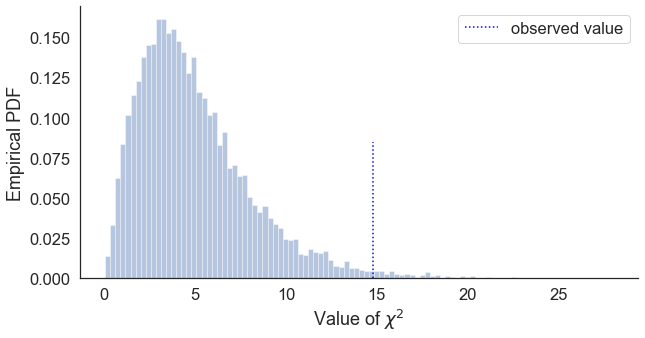

We need to set a confidence level and compute the corresponding critical value, beyond which we will reject the null hypothesis of a fair dice. A typical choice is to set it to 95%.


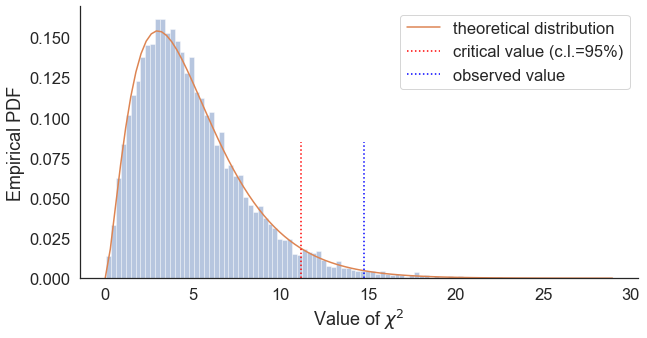

At the 95% confidence level we reject the null hypothesis that the dice is fair.

For reference, the weights used to generate the original count for our (maybe unfair) dice were
 [0.175 0.15  0.164 0.163 0.174 0.172]


In [20]:
weights = gen_close_weights()
counts = dice_roll_count_multinom(weights, size=6000)
print('Say we are presented with the counts (C_1, ..., C_6) = {}'.format(counts) + '. \nAre these compatible ' + 
      'with the hypothesis of a fair dice?')
obs_value = compute_chi2(counts)
print('\nThe value of the test statistic \chi^2 for our counts is {}'.format(obs_value) + '.\n' + 
     'Let us now simulate tossing a truly fair dice 10000 times and compute that same quantity for ' + 
      'each of the resulting counts.')

sim_values = sampling_chi2()

print('\nWhere does our observed value of \chi^2 lie within that distribution? \n' +
      'Is that enough to the right to conclude that the dice may not be fair?')
plot_sampling_distribution(sim_values, th_dist=False, obs_value=obs_value)

print('We need to set a confidence level and compute the corresponding critical value, beyond ' + 
      'which we will reject the null hypothesis of a fair dice. A typical choice is to set it to 95%.')

crit_value = np.percentile(sim_values, 95)
plot_sampling_distribution(sim_values, conf_lvl=95, obs_value=obs_value)

is_unfair(sim_values, conf_lvl=95, obs_value=obs_value)

print('\nFor reference, the weights used to generate the original count for our (maybe unfair) dice ' + 
      'were\n {}'.format(np.around(weights, decimals=3)))

del weights, counts, obs_value, sim_values, crit_value

### Bootstrap analysis

We could alternatively make use of bootstrap replicates:
* A bunch of values is generated sampling from the multinomial distribution and converted into the array with $C_i$ copies of $i$, for $i=1, ..., 6$ (alternatively we could use *dice_roll* )
* The array is resampled to produce bootstrap samples, from which the above $\chi^2$ statistic is computed. Plotting a histograms of such values (bootstrap replicates) provides a picture of its distribution for that dice.
* We can then work out a confidence interval for the mean of that statistic.
* The whole procedure can be repeated for a fair dice: comparison of the confidence intervals tells us whether to retain or reject the null hypothesis that the original dice is fair.

### Bootstrapping functions

Functions to construct bootstrap samples and bootstrap replicates from an original sample.

In [21]:
# Resample the original sample
def BS_sample(orig_sample):
    return gen.choice(orig_sample, size=len(orig_sample))

# Compute a statistic of interest on a bootstrap sample obtained from the original one.
def BS_replicate(orig_sample, func=compute_chi2):
    return func(dice_roll_count(BS_sample(orig_sample)))

Generate replicates and plot them in a histogram

In [22]:
def gen_replicates(orig_sample, n_repl = 10000, func=compute_chi2):
    replicates = np.empty(n_repl)
    for i in range(n_repl):
        replicates[i] = BS_replicate(orig_sample, func)

    return replicates    
    
def is_unfair_bootstrap(replicates, ref_replicates, conf_lvl, verbose=True):

    mean, std_dev = np.mean(replicates), np.std(replicates)
    mean_ref, std_dev_ref = np.mean(ref_replicates), np.std(ref_replicates)
    conf_int = np.percentile(replicates, [(100-conf_lvl)/2, 100 - (100-conf_lvl)/2])
    conf_int_ref = np.percentile(ref_replicates, [(100-conf_lvl)/2, 100 - (100-conf_lvl)/2])
    
    if verbose:
        print('The mean ± stddev of χ2 for the tested dice is: {0} ± {1}.'.format(mean, std_dev))
        print('At the {0}% confidence level the true mean of χ2 lies in the interval {1}.\n'.format(conf_lvl, conf_int))
        print('The mean ± stddev of χ2 for a reference fair dice is: {0} ± {1}.'.format(mean_ref, std_dev_ref))
        print('At the {0}% confidence level the true mean of χ2 lies in the interval {1}.\n'.format(conf_lvl, conf_int_ref))
    
    if conf_int[0] > conf_int_ref[1]:
        if verbose:
            print('At the {}% confidence level we reject the null hypothesis that the dice is fair.'.format(conf_lvl))
        return 'UNFAIR'
    else:
        if mean - std_dev > mean_ref + std_dev_ref:
            if verbose:
                print('The observed behaviour is compatible with the null hypothesis of a fair dice. \n' + 
                      'Nevertheless, the behaviour of this dice warrants further investigation.')
            return 'SUSPICIOUS'
        else:
            if verbose:
                print('The observed behaviour is compatible with the null hypothesis of a fair dice.')
            return 'FAIR'

def boxplot_replicates(replicates, ref_replicates):
    sns.set(style='white', rc={'figure.figsize':(10,5)}, font_scale=1.5)
    
    sns.boxplot(data=[replicates, ref_replicates], orient='h')
            
    sns.despine(left=True)
    plt.xlabel('Value of {} of the bootstrap samples'.format(r'$\chi^2$'))
    plt.yticks([0,1], ['tested dice', 'fair dice'], rotation=30)
    plt.show()   

#### A worked out example

Say we are presented with the counts (C_1, ..., C_6) = [ 890  948 1068 1103  975 1016]. 
Are these compatible with the hypothesis of a fair dice?

Let us resample with replacement the array containing C_1 1s, ..., C_6 6s for 10000 times. 
This is a bootstrap sample. For each one, we compute the χ2 statistic, our bootstrap replicate.

We can then repeat this bootstrap procedure using a fair dice for reference.
The output of these simulations can be visualised using the following boxplot.


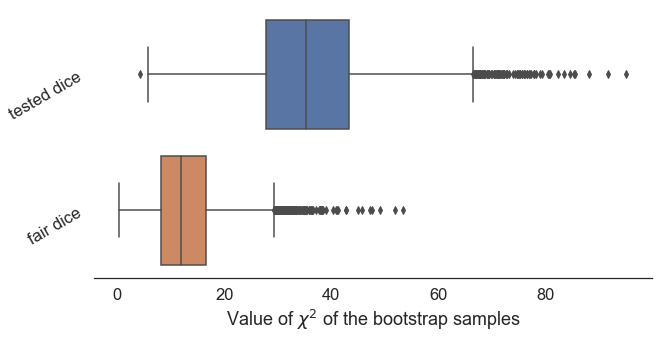

This is generally inconclusive, but for heavily loaded / essentially fair dice. 
We can set a confidence level of e.g. 95% and compute a few statistics helping us to decide: 
we choose mean and standard deviation of χ2, as well as the interval containing 95% of our replicates.

The mean ± stddev of χ2 for the tested dice is: 36.1228178 ± 11.54082812396074.
At the 95% confidence level the true mean of χ2 lies in the interval [16.20325 61.4261 ].

The mean ± stddev of χ2 for a reference fair dice is: 12.8779918 ± 6.484037095416155.
At the 95% confidence level the true mean of χ2 lies in the interval [ 3.0978  28.08425].

The observed behaviour is compatible with the null hypothesis of a fair dice. 
Nevertheless, the behaviour of this dice warrants further investigation.
The verdict is: SUSPICIOUS

For reference, the weights used to generate the original count for our (maybe unfair) dice were
 [0.15020136 0.15870891 0.16910494 0.1796943  0.17539251 0.16689798]


In [23]:
weights = gen_close_weights(upto=0.1)
counts = dice_roll_count_multinom(weights, size=6000)
print('Say we are presented with the counts (C_1, ..., C_6) = {}'.format(counts) + '. \nAre these compatible ' + 
      'with the hypothesis of a fair dice?')

replicates = gen_replicates(expand_counts(counts), func=compute_chi2)
print('\nLet us resample with replacement the array containing C_1 1s, ..., C_6 6s for 10000 times.' + 
        ' \nThis is a bootstrap sample. For each one, we compute the χ2 statistic, our bootstrap replicate.')

replicates_ref = gen_replicates(expand_counts(dice_roll_count_multinom(gen_close_weights(upto=0))), func=compute_chi2)
print('\nWe can then repeat this bootstrap procedure using a fair dice for reference.')

print('The output of these simulations can be visualised using the following boxplot.')
boxplot_replicates(replicates, replicates_ref)

print('This is generally inconclusive, but for heavily loaded / essentially fair dice. ' + 
        '\nWe can set a confidence level of e.g. 95% and compute a few statistics helping us to decide: ' + 
        '\nwe choose mean and standard deviation of χ2, as well as the interval containing 95% of our replicates.\n')

print('The verdict is: {}'.format(is_unfair_bootstrap(replicates, replicates_ref, conf_lvl=95, verbose=True)))

print('\nFor reference, the weights used to generate the original count for our (maybe unfair) dice ' + 
        'were\n {}'.format(weights))

del weights, counts, replicates, replicates_ref

**Note for improvements**: I don't really know how to make the bootstrap analysis more conclusive. I want to really be able to say *At the 95% confidence level we reject the hypothesis that the dice is fair*, but I need to understand how to set up the hypothesis test.

## Constructing a DataFrame of observations

We create a DataFrame simulating a number of dice. We imagine tossing each one a number of times and, beside recording the number of times that each face came up, we also compute a few metrics from the counts, namely the mean, the standard deviation and $\chi^2$.

We already know that almost all these features are relatively weak indicators of the fairness of a dice, unless the deviation from the expected behaviour of a fair dice is too big not to notice. For instance, egregiously unfair dice may accurately reproduce the expected mean of 3.5 if the weights are 'symmetrically skewed', e.g. for $w_1 = w_6 = 1/4$, $w_2 = w_3 = w_4 = w_5 = 1/8$.

We will call a dice 
* 'fair' if the weights of its faces do not differ from 1/6 by more than 5%;
* 'suspicious' if the weights of its faces differ from 1/6 by more than 5% and less than 10%;
* 'unfair' if the weights of its faces differ from 1/6 by more than 10%.

Note that if we draw the weights using the *gen_close_weights* function, the *upto* parameter sets an upper bound on the relative difference between each weight and 1/6, but no lower bound. Therefore, pretty fair weights might be drawn for a dice that is set for unfairness. 

To prevent having really murky boundaries separating fair, suspicious and unfair dice, we write a new function to generate weights. The most notable features are that
* we can specify both a minimal and a maximal deviation from the optimal weights
* we force three deviations to be negative and three positive

Note that the final rescaling of the weights (to have them sum to 1) can affect the relative differences (though typically not by much) pushing them across the 5% or 10% boundaries. It can also happen that a small positive deviation becomes negative or viceversa.

In [24]:
def gen_weights_inrange(min_deviation, max_deviation, n_weights=6, sum=1):
    arr_perc = gen.uniform(min_deviation, max_deviation, n_weights)
    arr = np.array([(1 + np.random.choice([-1, -1, -1, 1, 1, 1], replace=False)*arr_perc[i])/n_weights 
                    for i in range(n_weights)])
    return arr/(arr.sum())

To decide on what kind of dice we are going to simulate, we will sample from an exponential distribution, which is rapidly decreasing, associating lower values to fairer dice. The following histogram is just for the sake of visualising the distribution and picking an appropriate value of the *scale* parameter.

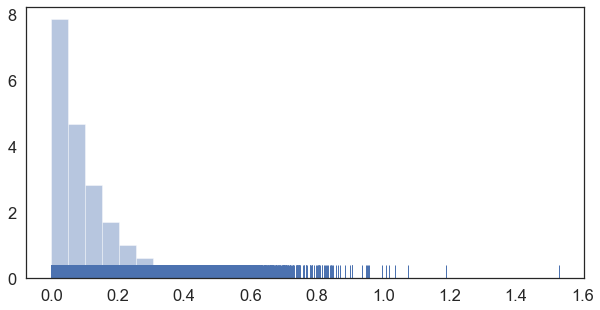

In [25]:
sns.distplot(gen.exponential(scale=0.1, size=100000), bins=30, kde=False, rug=True, norm_hist=True);

In [26]:
def simulate_dice(n_rolls=6000):
    fromexp = gen.exponential(scale=0.1)
    if fromexp < 0.05:
        min_dev, max_dev = 0, 0.05
        fairness_of_dice = 'FAIR'
    elif fromexp < 0.1:
        min_dev, max_dev = 0.05, 0.1
        fairness_of_dice = 'SUSPICIOUS'
    else:
        min_dev, max_dev = 0.1, 1
        fairness_of_dice = 'UNFAIR'

    weights = gen_weights_inrange(min_deviation=min_dev, max_deviation=max_dev) # Don't round, otherwise the sum might exceed 1!
    rel_dev = np.around([(w - 1/6)/(1/6) for w in weights], decimals=3)
    counts = dice_roll_count_multinom(weights, size=n_rolls)
    mean = np.around(np.mean(expand_counts(counts)), decimals=3)
    std_dev = np.around(np.std(expand_counts(counts)), decimals=3)
    chi2 = np.around(compute_chi2(counts), decimals=3)
    
    return np.concatenate((np.array([np.around(fromexp, decimals=3), np.around(weights, decimals=3), rel_dev]), counts, 
                           np.array([mean, std_dev, chi2, fairness_of_dice])))

In [27]:
data = [simulate_dice() for i in range(10000)]
lst_col = ['fromexp', 'weights', 'relative_deviation', '# 1s', '# 2s', '# 3s', '# 4s', '# 5s', '# 6s', 
           'mean', 'std_dev', 'chi2', 'fairness']

df_orig = pd.DataFrame(data, columns=lst_col)
df_orig[['mean', 'std_dev', 'chi2']] = df_orig[['mean', 'std_dev', 'chi2']].astype('float64')

df_orig.head()

df_orig[df_orig['fairness']=='FAIR'].shape
df_orig[df_orig['fairness']=='SUSPICIOUS'].shape
df_orig[df_orig['fairness']=='UNFAIR'].shape

,fromexp,weights,relative_deviation,# 1s,# 2s,# 3s,# 4s,# 5s,# 6s,mean,std_dev,chi2,fairness
0,0.120,"[0.126, 0.055, 0.292, 0.18, 0.103, 0.244]","[-0.244, -0.672, 0.752, 0.079, -0.382, 0.466]",780,326,1762,1033,617,1482,3.804,1.653,1463.422,UNFAIR
1,0.051,"[0.179, 0.18, 0.176, 0.155, 0.156, 0.154]","[0.071, 0.079, 0.058, -0.069, -0.066, -0.073]",1047,1070,1059,876,961,987,3.432,1.719,27.656,SUSPICIOUS
2,0.224,"[0.18, 0.191, 0.214, 0.244, 0.044, 0.126]","[0.079, 0.149, 0.284, 0.463, -0.734, -0.241]",1103,1130,1294,1405,276,792,3.166,1.582,845.410,UNFAIR
3,0.134,"[0.198, 0.042, 0.316, 0.072, 0.264, 0.108]","[0.185, -0.746, 0.898, -0.57, 0.585, -0.351]",1210,284,1833,450,1570,653,3.474,1.652,1998.454,UNFAIR
4,0.204,"[0.198, 0.287, 0.089, 0.081, 0.065, 0.28]","[0.187, 0.72, -0.466, -0.514, -0.607, 0.679]",1216,1704,508,480,430,1662,3.365,1.955,1817.880,UNFAIR


(3967, 13)

(2389, 13)

(3644, 13)

Out of 10000 simulated dice, roughly (40%, 25%, 35%) should be classified as fair, suspicious, unfair. Looks good. We can always go back and tweak the threshold for fairness or (probably better) the scale of the exponential distribution to alter those figures.

## Develop a supervised learning algorithm to identify (un)fair dice

This is obviously a classification task, where the target variable is *fairness_of_dice* and everything else but *max_deviation* and *weights* (which are recorded for reference) is a predictor variable.

In [47]:
df_X = df_orig.loc[:, '# 1s':'chi2']
df_y = df_orig.iloc[:,-1].replace({'FAIR':0, 'SUSPICIOUS':1, 'UNFAIR':2})

df_X.head()
df_y.head()

,# 1s,# 2s,# 3s,# 4s,# 5s,# 6s,mean,std_dev,chi2
0,780,326,1762,1033,617,1482,3.804,1.653,1463.422
1,1047,1070,1059,876,961,987,3.432,1.719,27.656
2,1103,1130,1294,1405,276,792,3.166,1.582,845.410
3,1210,284,1833,450,1570,653,3.474,1.652,1998.454
4,1216,1704,508,480,430,1662,3.365,1.955,1817.880


0    2
1    1
2    2
3    2
4    2
Name: fairness, dtype: int64

###### Scatter matrices

The following scatter matrices are here just for illustrative purposes. We already know that it cannot be very illuminating, as at least fair and suspicious dice are rather clustered together, but oh well. At least they illustrate how the behaviour of unfair dice is all over the place and in the vast majority of cases nowhere near that of fair ones.

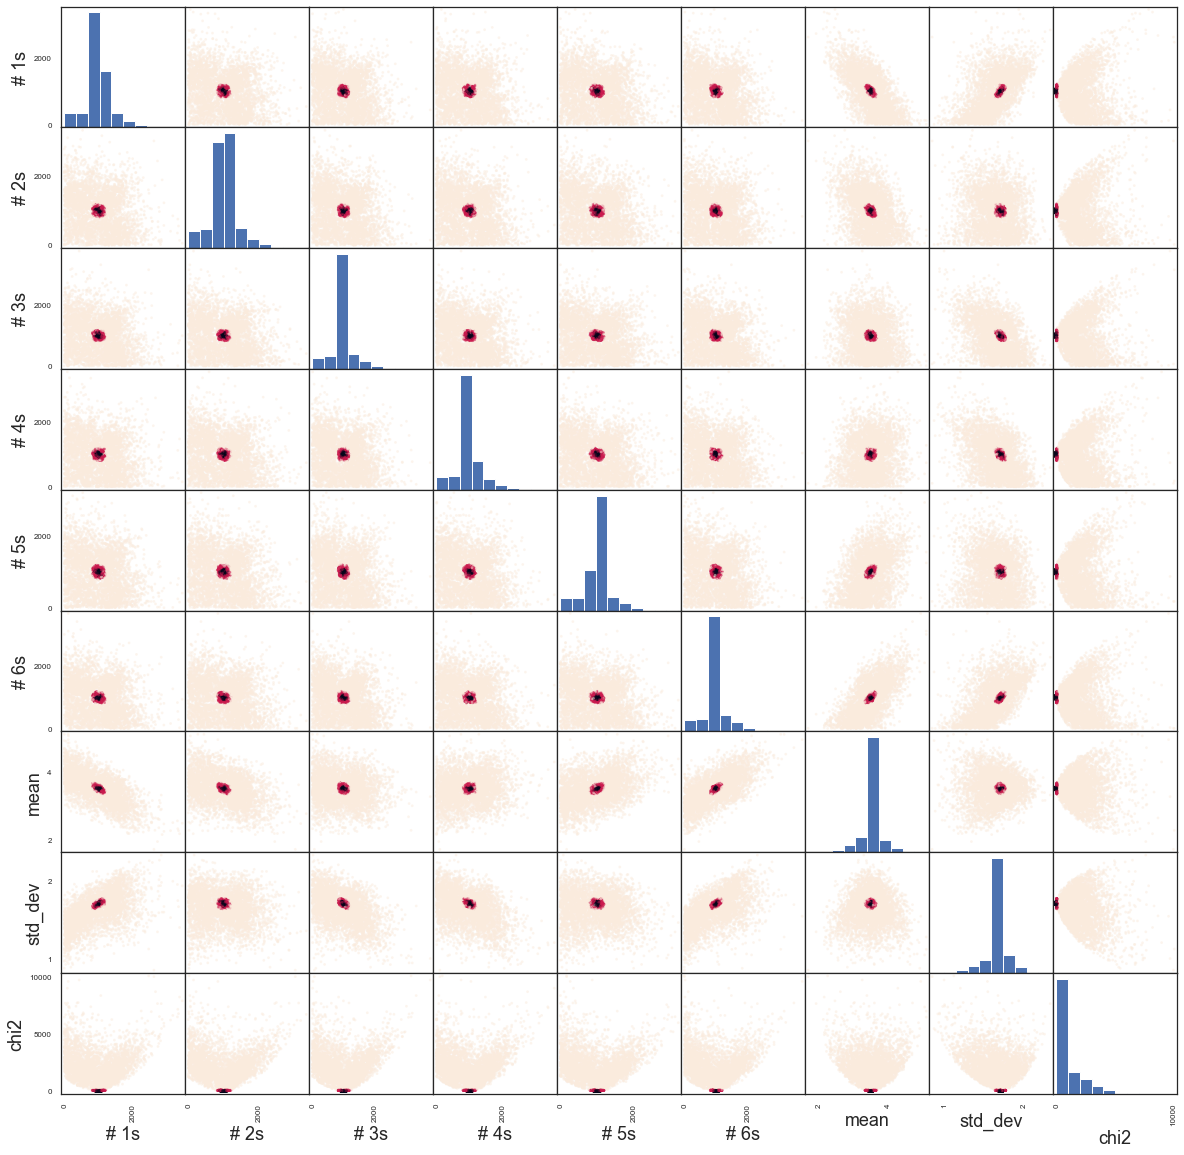

In [29]:
pd.plotting.scatter_matrix(df_X, c=df_y, figsize=[20, 20], s=30, marker='.');

The above is clearly hard to read. We can plot a similar graph with Seaborn and make it a bit more appealing. In the interest of readability, we retain just one column pertaining to the number of times a given face was drawn. Moreover, we play with *hue_order* to avoid green markers to be covered by orange and brown ones (that is, what we see now is not the complete picture, there are dots of different colours - mostly orange - hiding below the green ones).
This hints to the fact that the real challenge will be to distinguish the fair dice from the suspicious ones.

**Note for improvement**: The *chi2* column takes values across 3-4 orders of magnitude. Representing them on a log scale would be great, but I don't know how to do it selectively in a pairplot.

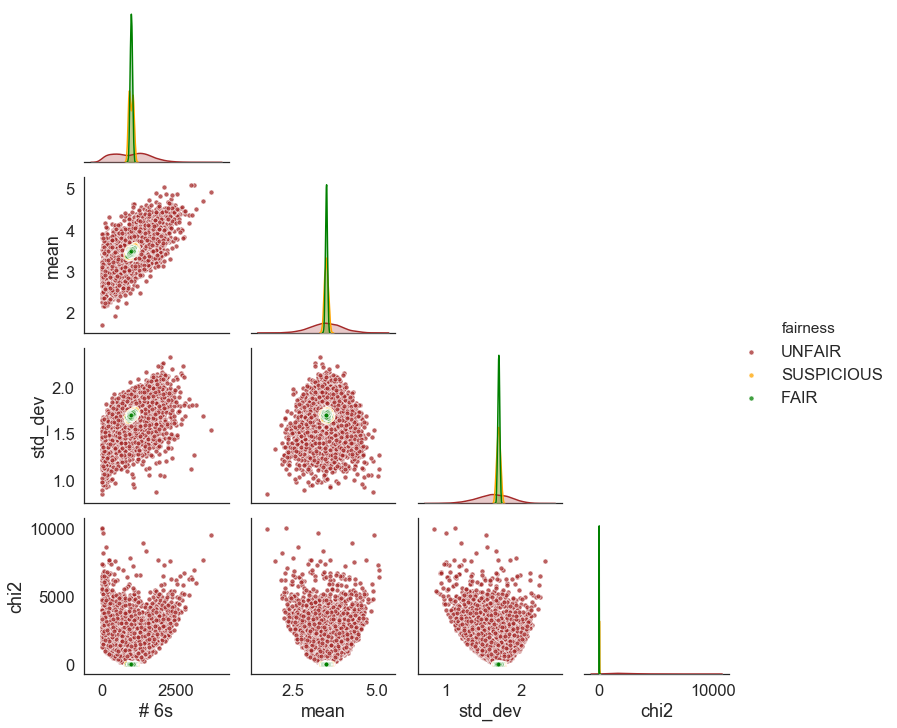

In [30]:
sns.pairplot(df_orig.loc[:, '# 6s':], hue='fairness', hue_order=['UNFAIR','SUSPICIOUS', 'FAIR'], 
             palette=['brown', 'orange', 'green'], corner=True, markers='.', plot_kws={'s':100, 'alpha':0.75});

### $k$-NearestNeighbours classification with all predictor variables

We first employ a KNN model on our DataFrame without additional considerations. After splitting its rows into train and test data, we compare training/testing accuracy for different values of the n_neighbors parameter.

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=42, stratify=df_y)

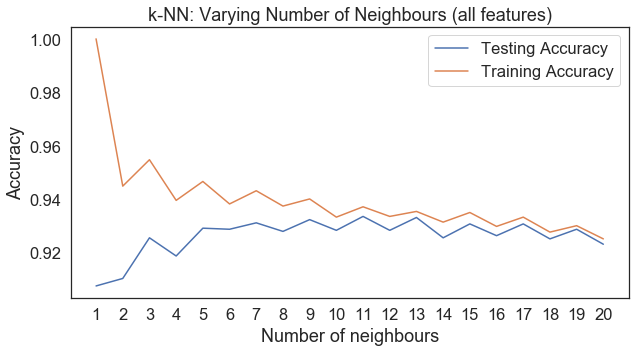

In [49]:
neighbours = np.arange(1, 21)
train_accuracy = np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))


for i, k in enumerate(neighbours):

    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train);
    
    #Compute accuracy on the training/testing set
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Plot the results

sns.lineplot(neighbours, test_accuracy, label = 'Testing Accuracy');
sns.lineplot(neighbours, train_accuracy, label = 'Training Accuracy');
plt.legend();
plt.title('k-NN: Varying Number of Neighbours (all features)');
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy');
plt.xticks(neighbours)
plt.show();

Overall the model seems to correctly identify the vast majority of dice and *n_neighbors = 5* seems a reasonable choice of optimal parameter.

In [50]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

knn.score(X_test, y_test)

# How wrong were we?
np.unique(y_pred - y_test, return_counts=True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

0.9292

(array([-1,  0,  1]), array([ 133, 2323,   44]))

Misidentifications occurred mostly in one direction, i.e. our model appears positively biased: some suspicious dice were identified as fair and possibly some unfair ones as suspicious. No unfair dice was mistaken for a fair one (or viceversa), although repeating the experiment enough times it certainly does happen.

Can we improve on this performance? We could
* discard features that I know can't be taken seriously, i.e. # 1s,..., # 6s. Possibly the mean / stddev as well. 
* use a StandardScaler to preprocess the data.

### $k$-NearestNeighbours classification after discarding some predictor variables

#### Discard counts of faces

We start over redefining the working DataFrame and splitting it into train/test data. Then we look at model performance as a function of the number of neighbours.

In [51]:
df_X = df_orig.loc[:, 'mean':'chi2']
df_y = df_orig.iloc[:,-1].replace({'FAIR':0, 'SUSPICIOUS':1, 'UNFAIR':2})

df_X.head()
df_y.head()

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=42, stratify=df_y)

,mean,std_dev,chi2
0,3.804,1.653,1463.422
1,3.432,1.719,27.656
2,3.166,1.582,845.410
3,3.474,1.652,1998.454
4,3.365,1.955,1817.880


0    2
1    1
2    2
3    2
4    2
Name: fairness, dtype: int64

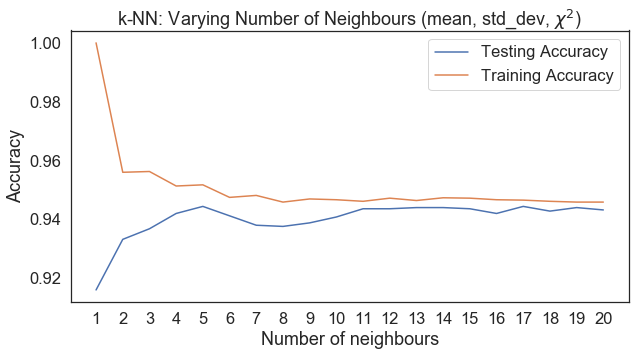

In [52]:
neighbours = np.arange(1, 21)
train_accuracy = np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))


for i, k in enumerate(neighbours):

    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train);
    
    #Compute accuracy on the training/testing set
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Plot the results

sns.lineplot(neighbours, test_accuracy, label = 'Testing Accuracy');
sns.lineplot(neighbours, train_accuracy, label = 'Training Accuracy');
plt.legend();
plt.title('k-NN: Varying Number of Neighbours (mean, std_dev, $\chi^2$)');
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy');
plt.xticks(neighbours)
plt.show();

We achieved a performance improvement and *n_neighbours = 5* looks like the optimal choice for our hyperparameter.

In [53]:
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

knn.score(X_test, y_test)

# How wrong were we?
np.unique(y_pred - y_test, return_counts=True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

0.9444

(array([-1,  0,  1]), array([  89, 2361,   50]))

As in the previous analysis, our model is positively biased, but not as much anymore (fewer suspicious dice were identified as fair). 

#### Discard mean and std_dev

We start over redefining the working DataFrame and splitting it into train/test data. Then we look at model performance as a function of the number of neighbours.

In [54]:
df_X = df_orig.iloc[:, [3, 4, 5, 6, 7, 8, 11]]
df_y = df_orig.iloc[:,-1].replace({'FAIR':0, 'SUSPICIOUS':1, 'UNFAIR':2})

df_X.head()
df_y.head()

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=42, stratify=df_y)

,# 1s,# 2s,# 3s,# 4s,# 5s,# 6s,chi2
0,780,326,1762,1033,617,1482,1463.422
1,1047,1070,1059,876,961,987,27.656
2,1103,1130,1294,1405,276,792,845.410
3,1210,284,1833,450,1570,653,1998.454
4,1216,1704,508,480,430,1662,1817.880


0    2
1    1
2    2
3    2
4    2
Name: fairness, dtype: int64

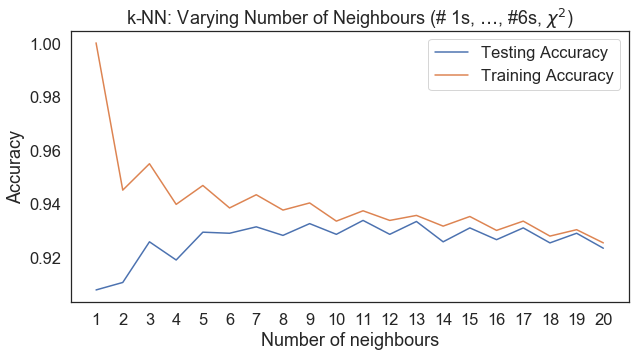

In [55]:
neighbours = np.arange(1, 21)
train_accuracy = np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))


for i, k in enumerate(neighbours):

    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_train, y_train);
    
    #Compute accuracy on the training/testing set
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Plot the results

sns.lineplot(neighbours, test_accuracy, label = 'Testing Accuracy');
sns.lineplot(neighbours, train_accuracy, label = 'Training Accuracy');
plt.legend();
plt.title('k-NN: Varying Number of Neighbours (# 1s, $\dots$, #6s, $\chi^2$)');
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy');
plt.xticks(neighbours)
plt.show();

In [61]:
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

knn.score(X_test, y_test)

# How wrong were we?
np.unique(y_pred - y_test, return_counts=True)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

0.9312

(array([-1,  0,  1]), array([ 136, 2328,   36]))

We achieved essentially the same results as in our first attempt: it looks like our model bases its evaluation much more on the number of outcomes than on their mean or standard deviation. Trying to retain one of *mean* and *std_dev* doesn't help; trying to discard some of the columns recording the number of times a given face came up doesn't either. 

### $k$-NearestNeighbours classification after preprocessing the DataFrame

We observed that the features appearing in our DataFrame take very different values and their ranges are also very disparate. We will therefore set up a pipeline that transforms our working DataFrame before training the classifier model on it. Specifically, we will make use of a StandardScaler.

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Without discarding columns

In [63]:
df_X = df_orig.loc[:, '# 1s':'chi2']
df_y = df_orig.iloc[:,-1].replace({'FAIR':0, 'SUSPICIOUS':1, 'UNFAIR':2})

df_X.head()
df_y.head()

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=42, stratify=df_y)

,# 1s,# 2s,# 3s,# 4s,# 5s,# 6s,mean,std_dev,chi2
0,780,326,1762,1033,617,1482,3.804,1.653,1463.422
1,1047,1070,1059,876,961,987,3.432,1.719,27.656
2,1103,1130,1294,1405,276,792,3.166,1.582,845.410
3,1210,284,1833,450,1570,653,3.474,1.652,1998.454
4,1216,1704,508,480,430,1662,3.365,1.955,1817.880


0    2
1    1
2    2
3    2
4    2
Name: fairness, dtype: int64

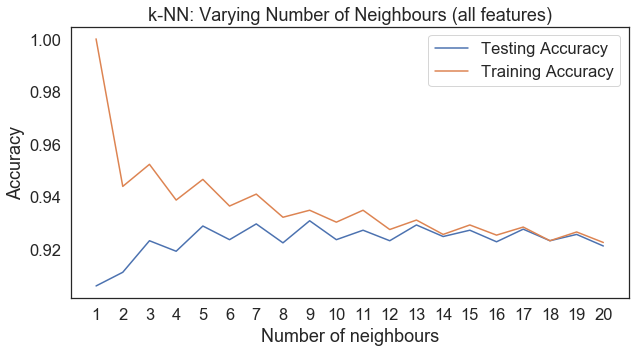

In [64]:
neighbours = np.arange(1, 21)
train_accuracy = np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i, k in enumerate(neighbours):
    
    steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=k))]
    pipeline = Pipeline(steps)

    pipeline.fit(X_train, y_train);
    
    #Compute accuracy on the training/testing set
    train_accuracy[i] = pipeline.score(X_train, y_train)
    test_accuracy[i] = pipeline.score(X_test, y_test)

# Plot the results

sns.lineplot(neighbours, test_accuracy, label = 'Testing Accuracy');
sns.lineplot(neighbours, train_accuracy, label = 'Training Accuracy');
plt.legend();
plt.title('k-NN: Varying Number of Neighbours (all features)');
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy');
plt.xticks(neighbours)
plt.show();

Comparing with the unscaled case, very little has changed, with *n_neighbours = 5* a reasonably optimal parameter.

In [68]:
pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=5))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

pipeline.score(X_test, y_test)

# How wrong were we?
np.unique(y_pred - y_test, return_counts=True)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

0.9288

(array([-1,  0,  1]), array([ 136, 2322,   42]))

What if we again get rid of the counts?

#### Discard counts of faces

In [69]:
df_X = df_orig.loc[:, 'mean':'chi2']
df_y = df_orig.iloc[:,-1].replace({'FAIR':0, 'SUSPICIOUS':1, 'UNFAIR':2})

df_X.head()
df_y.head()

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=42, stratify=df_y)

,mean,std_dev,chi2
0,3.804,1.653,1463.422
1,3.432,1.719,27.656
2,3.166,1.582,845.410
3,3.474,1.652,1998.454
4,3.365,1.955,1817.880


0    2
1    1
2    2
3    2
4    2
Name: fairness, dtype: int64

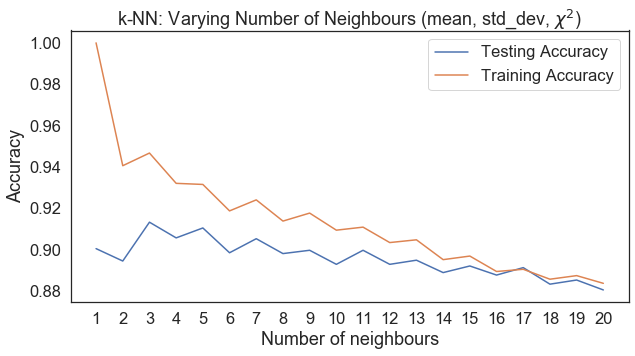

In [70]:
neighbours = np.arange(1, 21)
train_accuracy = np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i, k in enumerate(neighbours):
    
    steps = [('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=k))]
    pipeline = Pipeline(steps)

    pipeline.fit(X_train, y_train);
    
    #Compute accuracy on the training/testing set
    train_accuracy[i] = pipeline.score(X_train, y_train)
    test_accuracy[i] = pipeline.score(X_test, y_test)

# Plot the results

sns.lineplot(neighbours, test_accuracy, label = 'Testing Accuracy');
sns.lineplot(neighbours, train_accuracy, label = 'Training Accuracy');
plt.legend();
plt.title('k-NN: Varying Number of Neighbours (mean, std_dev, $\chi^2$)');
plt.xlabel('Number of neighbours')
plt.ylabel('Accuracy');
plt.xticks(neighbours)
plt.show();

Nope, even the optimal choice *n_neighbours = 3* is noticeably below the previous performances.

In [71]:
pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_neighbors=3))])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

pipeline.score(X_test, y_test)

# How wrong were we?
np.unique(y_pred - y_test, return_counts=True)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=3, p=2,
                                      weights='uniform'))],
         verbose=False)

0.9132

(array([-1,  0,  1]), array([ 150, 2283,   67]))

It must be because the feature that is most affected by the rescaling step also happens to be the best predictor of the fairness of a dice. We didn't do the k-NN algorithm any favour by making it look like a pretty useless metric like the mean!